Question 1

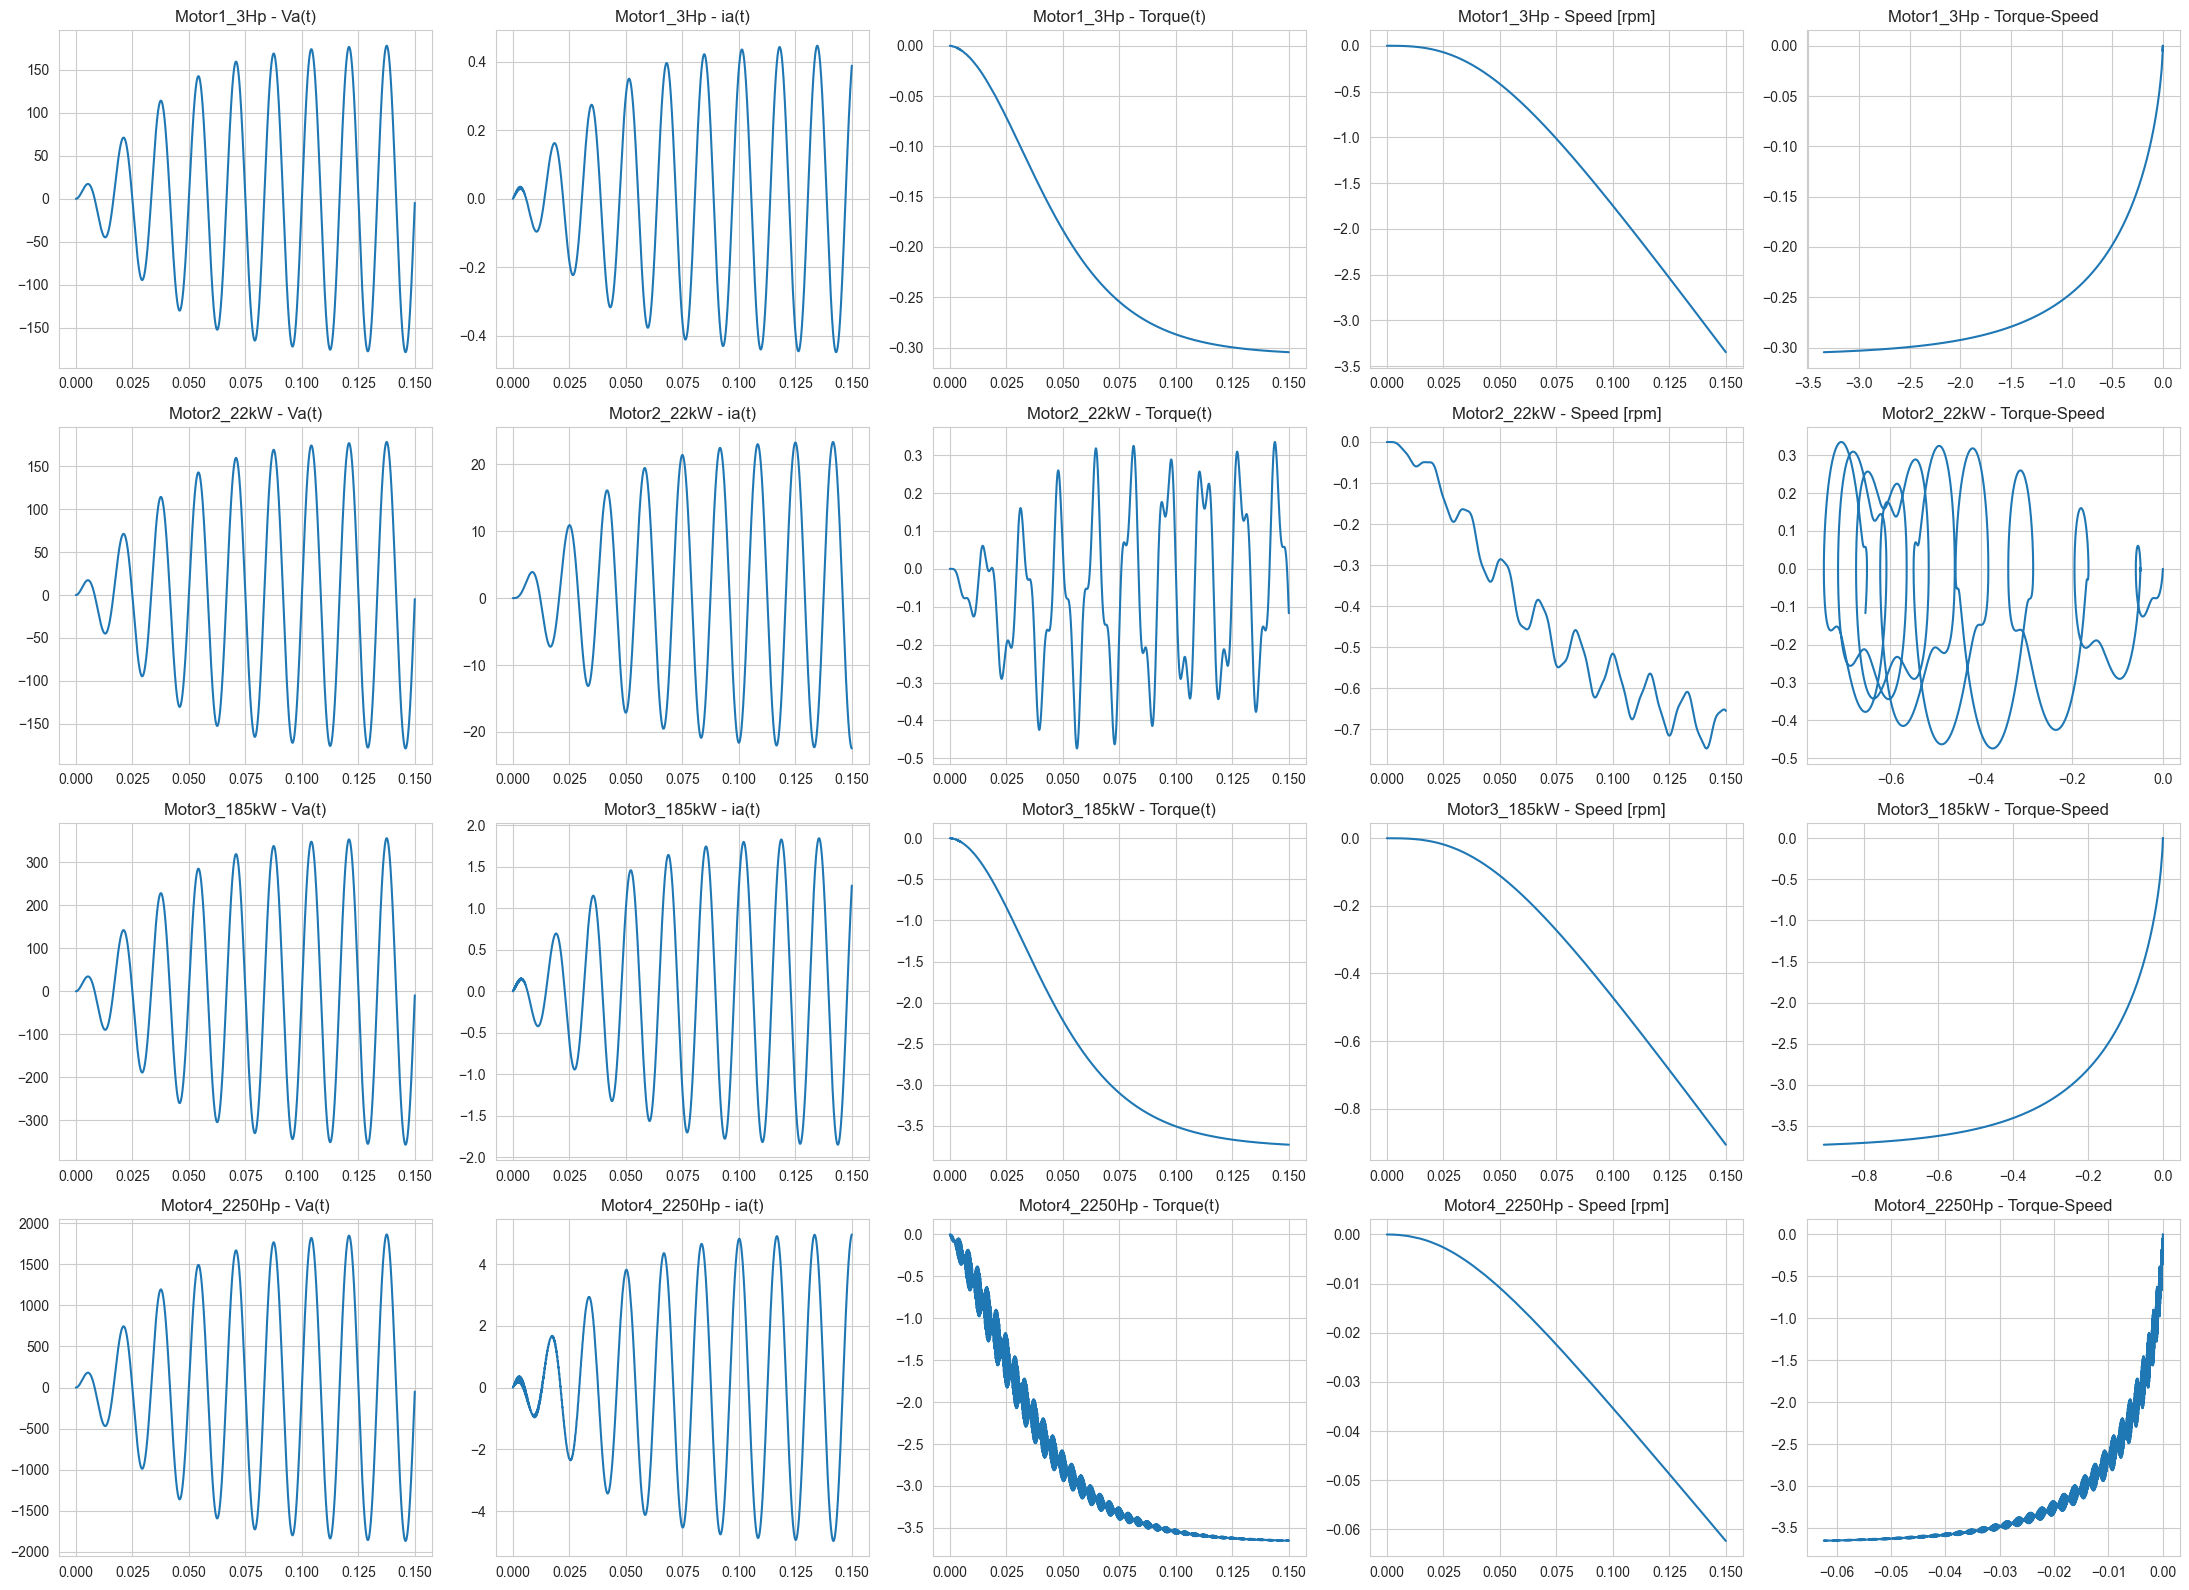

In [ ]:
motor_configs = {
    "Motor1_3Hp": {
        "Rs": 0.435,
        "Rr": 0.816,
        "Ls": 2e-3,
        "Lr": 2e-3,
        "Lm": 69.4e-3,
        "J": 0.089,
        "Vll": 220,
    },
    "Motor2_22kW": {
        "Rs": 0.044,
        "Rr": 0.0252,
        "Ls": 0.55e-3 + 12.9e-3,
        "Lr": 0.47e-3 + 12.9e-3,
        "Lm": 12.9e-3,
        "J": 0.122,
        "Vll": 220,
    },
    "Motor3_185kW": {
        "Rs": 0.013,
        "Rr": 0.075,
        "Ls": 0.1e-3,
        "Lr": 0.1e-3,
        "Lm": 12e-3,
        "J": 4.0,
        "Vll": 440,
    },
    "Motor4_2250Hp": {
        "Rs": 0.0292,
        "Rr": 0.0222,
        "Ls": 0.601e-3,
        "Lr": 0.601e-3,
        "Lm": 34.6e-3,
        "J": 63.87,
        "Vll": 2300,
    }
}

def rk4_simulate_motor(name, cfg):
    Vph_peak = cfg["Vll"] / np.sqrt(3) * np.sqrt(2)
    Rs, Rr, Ls, Lr, Lm, J = cfg["Rs"], cfg["Rr"], cfg["Ls"], cfg["Lr"], cfg["Lm"], cfg["J"]

    state = np.zeros(6)
    va_list, ia_list, Te_list, w_list, t_list = [], [], [], [], []
    ia_peak_prev = 0.0
    stable_counter = 0
    settle_index = len(time)

    def derivatives(state, t, Va, Vb, Vc):
        ids, iqs, idr, iqr, w_r, theta_r = state
        cos_t, sin_t = np.cos(theta_r), np.sin(theta_r)

        # Vds = (2/3)*(Va*cos_t + Vb*np.cos(theta_r - 2*np.pi/3) + Vc*np.cos(theta_r + 2*np.pi/3))
        # Vqs = (2/3)*(-Va*sin_t - Vb*np.sin(theta_r - 2*np.pi/3) - Vc*np.sin(theta_r + 2*np.pi/3))

        # Vds = (2/3)*(Va*np.cos(theta_r) + Vb*np.cos(theta_r - 2*np.pi/3) + Vc*np.cos(theta_r + 2*np.pi/3))
        # Vqs = (2/3)*(-Va*np.sin(theta_r) - Vb*np.sin(theta_r - 2*np.pi/3) - Vc*np.sin(theta_r + 2*np.pi/3))


        Vds = (2/3)*(Va*np.cos(theta_r) + Vb*np.cos(theta_r - 2*np.pi/3) + Vc*np.cos(theta_r + 2*np.pi/3))
        Vqs = (2/3)*(-Va*np.sin(theta_r) - Vb*np.sin(theta_r - 2*np.pi/3) - Vc*np.sin(theta_r + 2*np.pi/3))

        lam_ds = Ls * ids + Lm * idr
        lam_qs = Ls * iqs + Lm * iqr
        lam_dr = Lr * idr + Lm * ids
        lam_qr = Lr * iqr + Lm * iqs

        d_ids = (Vds - Rs*ids + we*lam_qs) / Ls
        d_iqs = (Vqs - Rs*iqs - we*lam_ds) / Ls
        d_idr = (-Rr*idr + (we - w_r)*lam_qr) / Lr
        d_iqr = (-Rr*iqr - (we - w_r)*lam_dr) / Lr
        Te = (3/2) * (P/2) * Lm * (iqr * ids - idr * iqs)
        d_w_r = Te / J

        return np.array([d_ids, d_iqs, d_idr, d_iqr, d_w_r, w_r]), Te

    for i, t in enumerate(time):
        ramp = np.tanh(t / 0.05)
        Va = ramp * Vph_peak * np.sin(we * t)
        Vb = ramp * Vph_peak * np.sin(we * t - 2*np.pi/3)
        Vc = ramp * Vph_peak * np.sin(we * t + 2*np.pi/3)

        k1, Te1 = derivatives(state, t, Va, Vb, Vc)
        k2, _ = derivatives(state + 0.5 * dt * k1, t + 0.5 * dt, Va, Vb, Vc)
        k3, _ = derivatives(state + 0.5 * dt * k2, t + 0.5 * dt, Va, Vb, Vc)
        k4, _ = derivatives(state + dt * k3, t + dt, Va, Vb, Vc)
        state += (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

        ids, iqs, idr, iqr, w_r, theta_r = state

        cos_t, sin_t = np.cos(theta_r), np.sin(theta_r)
        ia = ids * cos_t - iqs * sin_t
        Te = Te1

        if i > 2 and i % int(1 / (f * dt)) == 0:
            ia_peak_now = max(np.abs(ia_list[-int(1 / (f * dt)):]), default=0)
            if ia_peak_prev != 0:
                change_ratio = abs(ia_peak_now - ia_peak_prev) / ia_peak_prev
                if change_ratio < 0.03:
                    stable_counter += 1
                    if stable_counter >= 3:
                        settle_index = i
                        break
                else:
                    stable_counter = 0
            ia_peak_prev = ia_peak_now

        va_list.append(Va)
        ia_list.append(ia)
        Te_list.append(Te)
        w_list.append(w_r * 60 / (2 * np.pi))
        t_list.append(t)

    return t_list, va_list, ia_list, Te_list, w_list, settle_index

# 시각화 (5개 subplot)
fig, axs = plt.subplots(4, 5, figsize=(22, 16))
for idx, (name, cfg) in enumerate(motor_configs.items()):
    t, va, ia, Te, w, settle = rk4_simulate_motor(name, cfg)
    row = idx

    axs[row, 0].plot(t, va)
    axs[row, 0].set_title(f"{name} - Va(t)")

    axs[row, 1].plot(t, ia)
    axs[row, 1].set_title(f"{name} - ia(t)")

    axs[row, 2].plot(t, Te)
    axs[row, 2].set_title(f"{name} - Torque(t)")

    axs[row, 3].plot(t, w)
    axs[row, 3].set_title(f"{name} - Speed [rpm]")

    axs[row, 4].plot(w, Te)
    axs[row, 4].set_title(f"{name} - Torque-Speed")

plt.tight_layout()
plt.show()


Question 2 - (1)

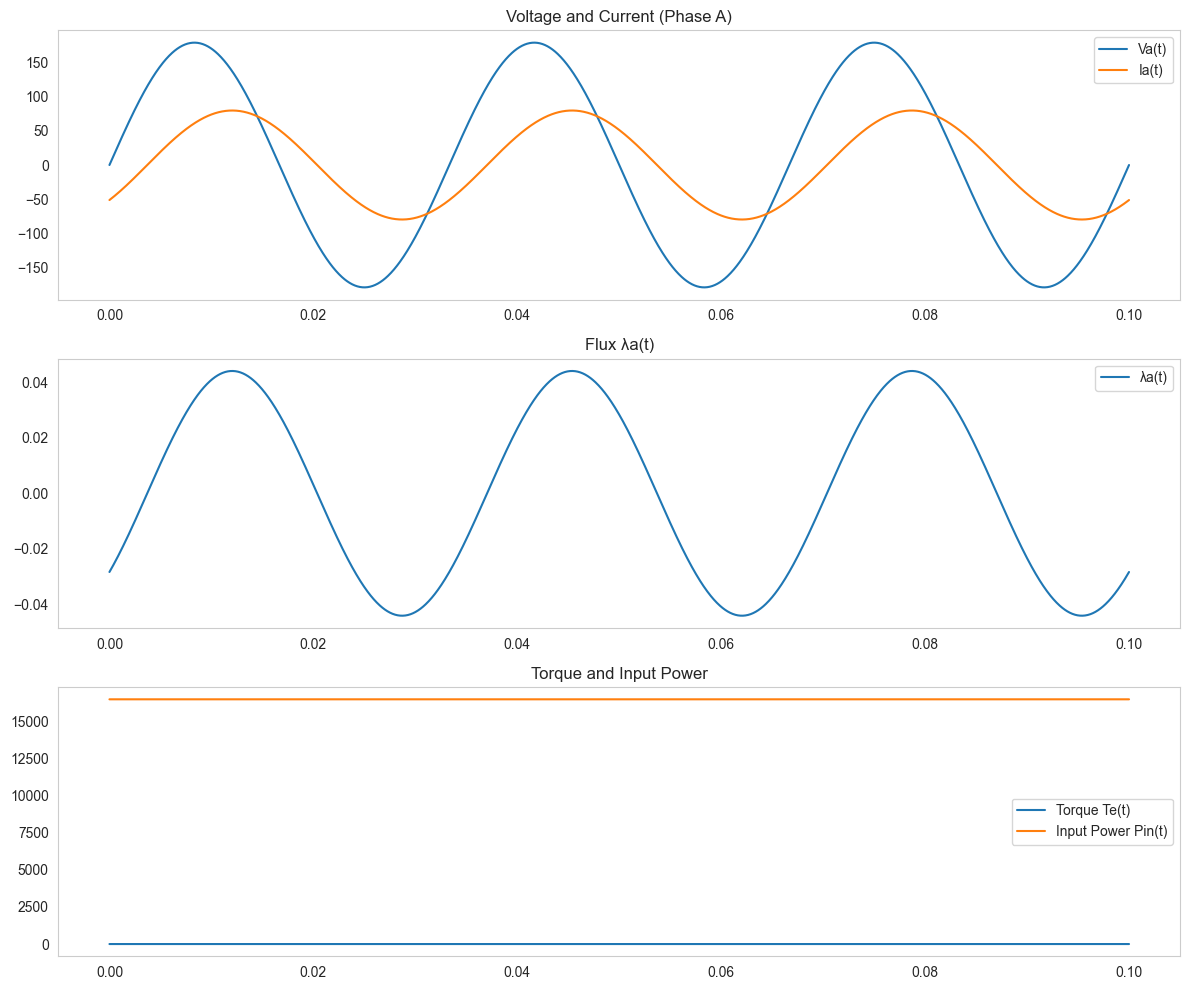

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 전동기 파라미터
f = 60  # Hz
P = 4   # 극수
w_s = 2 * np.pi * f / (P / 2)  # 동기 속도 [rad/s]
Vll = 220
V1 = Vll / np.sqrt(3)          # 상전압
Vm = np.sqrt(2) * V1           # peak voltage
Im = 80                        # 임의 기동 전류 peak (기동 전류 크다고 가정)
phi = np.deg2rad(40)           # 위상 지연 가정
Ls = 0.55e-3                   # [H]
Lm = 12.9e-3                   # [H]
J = 0.122                      # [kg·m^2]

# 시간축
t = np.linspace(0, 0.1, 2000)

# 고정자 전압 (abc 정현파)
Va = Vm * np.sin(w_s * t)
Vb = Vm * np.sin(w_s * t - 2*np.pi/3)
Vc = Vm * np.sin(w_s * t + 2*np.pi/3)

# 고정자 전류 (위상 지연 포함 정현파)
Ia = Im * np.sin(w_s * t - phi)
Ib = Im * np.sin(w_s * t - 2*np.pi/3 - phi)
Ic = Im * np.sin(w_s * t + 2*np.pi/3 - phi)

# 자속 (간단히: λa = Ls * Ia, λb = Ls * Ib, λc = Ls * Ic)
la = Ls * Ia
lb = Ls * Ib
lc = Ls * Ic

# 토크 근사: Te ∝ λa * Ib - λb * Ia (임의 기준, 정적 dq 변환 고려하지 않음)
Te = 1.5 * (P / 2) * (la * Ib - lb * Ia)

# 입력 전력
Pin = Va * Ia + Vb * Ib + Vc * Ic

# 결과 시각화
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(t, Va, label='Va(t)')
plt.plot(t, Ia, label='Ia(t)')
plt.legend(); plt.grid(); plt.title("Voltage and Current (Phase A)")

plt.subplot(3, 1, 2)
plt.plot(t, la, label='λa(t)')
plt.legend(); plt.grid(); plt.title("Flux λa(t)")

plt.subplot(3, 1, 3)
plt.plot(t, Te, label='Torque Te(t)')
plt.plot(t, Pin, label='Input Power Pin(t)')
plt.legend(); plt.grid(); plt.title("Torque and Input Power")

plt.tight_layout()
plt.show()


Question 2 - (2)

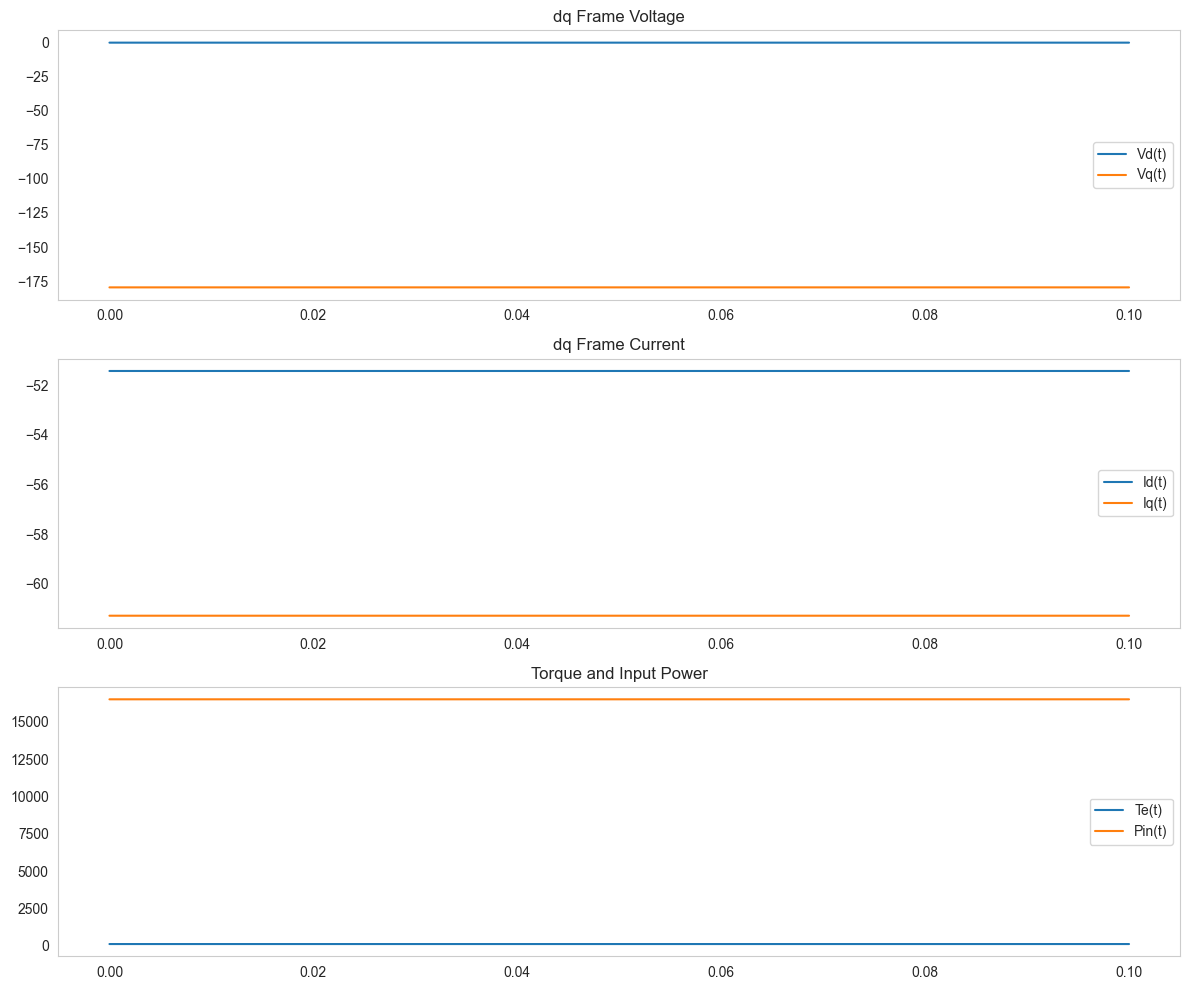

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 유도기 파라미터 (22kW motor)
f = 60
P = 4
w_s = 2 * np.pi * f / (P / 2)
Vll = 220
V1 = Vll / np.sqrt(3)
Vm = np.sqrt(2) * V1
Im = 80
phi = np.deg2rad(40)
Ls = 0.55e-3
Lm = 12.9e-3

# 시간 설정
t = np.linspace(0, 0.1, 2000)
theta = w_s * t  # 동기 회전각

# abc 전압 및 전류
Va = Vm * np.sin(w_s * t)
Vb = Vm * np.sin(w_s * t - 2*np.pi/3)
Vc = Vm * np.sin(w_s * t + 2*np.pi/3)

Ia = Im * np.sin(w_s * t - phi)
Ib = Im * np.sin(w_s * t - 2*np.pi/3 - phi)
Ic = Im * np.sin(w_s * t + 2*np.pi/3 - phi)

# abc → dq 변환 함수 (Clark + Park)
def abc_to_dq(a, b, c, theta):
    alpha = (2/3)*(a - 0.5*b - 0.5*c)
    beta  = (2/3)*(np.sqrt(3)/2)*(b - c)
    d =  alpha * np.cos(theta) + beta * np.sin(theta)
    q = -alpha * np.sin(theta) + beta * np.cos(theta)
    return d, q

Vd, Vq = abc_to_dq(Va, Vb, Vc, theta)
Id, Iq = abc_to_dq(Ia, Ib, Ic, theta)

# 자속
ld = Ls * Id
lq = Ls * Iq

# 토크 (근사식)
Te = 1.5 * (P / 2) * Lm * Id * Iq

# 입력 전력
Pin = 1.5 * (Vd * Id + Vq * Iq)

# 시각화
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(t, Vd, label='Vd(t)')
plt.plot(t, Vq, label='Vq(t)')
plt.title("dq Frame Voltage")
plt.legend(); plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, Id, label='Id(t)')
plt.plot(t, Iq, label='Iq(t)')
plt.title("dq Frame Current")
plt.legend(); plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, Te, label='Te(t)')
plt.plot(t, Pin, label='Pin(t)')
plt.title("Torque and Input Power")
plt.legend(); plt.grid()

plt.tight_layout()
plt.show()


Question 2 - (3)

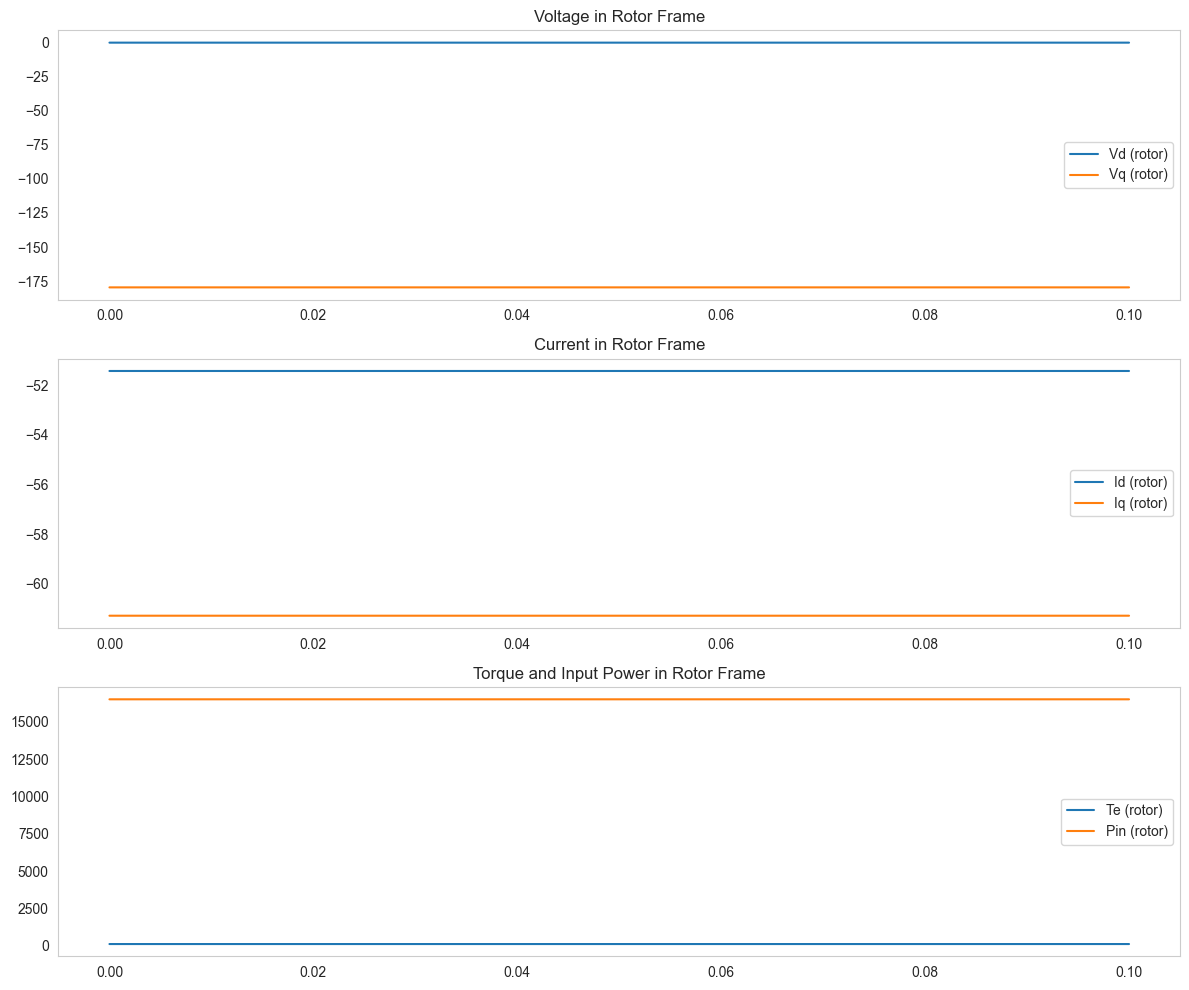

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 파라미터 (22kW motor)
f = 60
P = 4
w_s = 2 * np.pi * f / (P / 2)
w_r = 0  # 기동 시 회전자 속도 = 0
w_rel = w_s - w_r  # 상대 회전 속도
Vll = 220
V1 = Vll / np.sqrt(3)
Vm = np.sqrt(2) * V1
Im = 80
phi = np.deg2rad(40)
Ls = 0.55e-3
Lm = 12.9e-3

# 시간축
t = np.linspace(0, 0.1, 2000)
theta_rel = w_rel * t  # 회전자 기준에서 상대 회전각

# abc 전압/전류
Va = Vm * np.sin(w_s * t)
Vb = Vm * np.sin(w_s * t - 2*np.pi/3)
Vc = Vm * np.sin(w_s * t + 2*np.pi/3)

Ia = Im * np.sin(w_s * t - phi)
Ib = Im * np.sin(w_s * t - 2*np.pi/3 - phi)
Ic = Im * np.sin(w_s * t + 2*np.pi/3 - phi)

# abc → dq 변환 (회전자 기준)
def abc_to_dq(a, b, c, theta):
    alpha = (2/3)*(a - 0.5*b - 0.5*c)
    beta  = (2/3)*(np.sqrt(3)/2)*(b - c)
    d =  alpha * np.cos(theta) + beta * np.sin(theta)
    q = -alpha * np.sin(theta) + beta * np.cos(theta)
    return d, q

Vd, Vq = abc_to_dq(Va, Vb, Vc, theta_rel)
Id, Iq = abc_to_dq(Ia, Ib, Ic, theta_rel)

# 자속
ld = Ls * Id
lq = Ls * Iq

# 토크 (근사)
Te = 1.5 * (P / 2) * Lm * Id * Iq

# 입력 전력
Pin = 1.5 * (Vd * Id + Vq * Iq)

# 시각화
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(t, Vd, label='Vd (rotor)')
plt.plot(t, Vq, label='Vq (rotor)')
plt.title("Voltage in Rotor Frame")
plt.legend(); plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, Id, label='Id (rotor)')
plt.plot(t, Iq, label='Iq (rotor)')
plt.title("Current in Rotor Frame")
plt.legend(); plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, Te, label='Te (rotor)')
plt.plot(t, Pin, label='Pin (rotor)')
plt.title("Torque and Input Power in Rotor Frame")
plt.legend(); plt.grid()

plt.tight_layout()
plt.show()



Question 2 - (4)

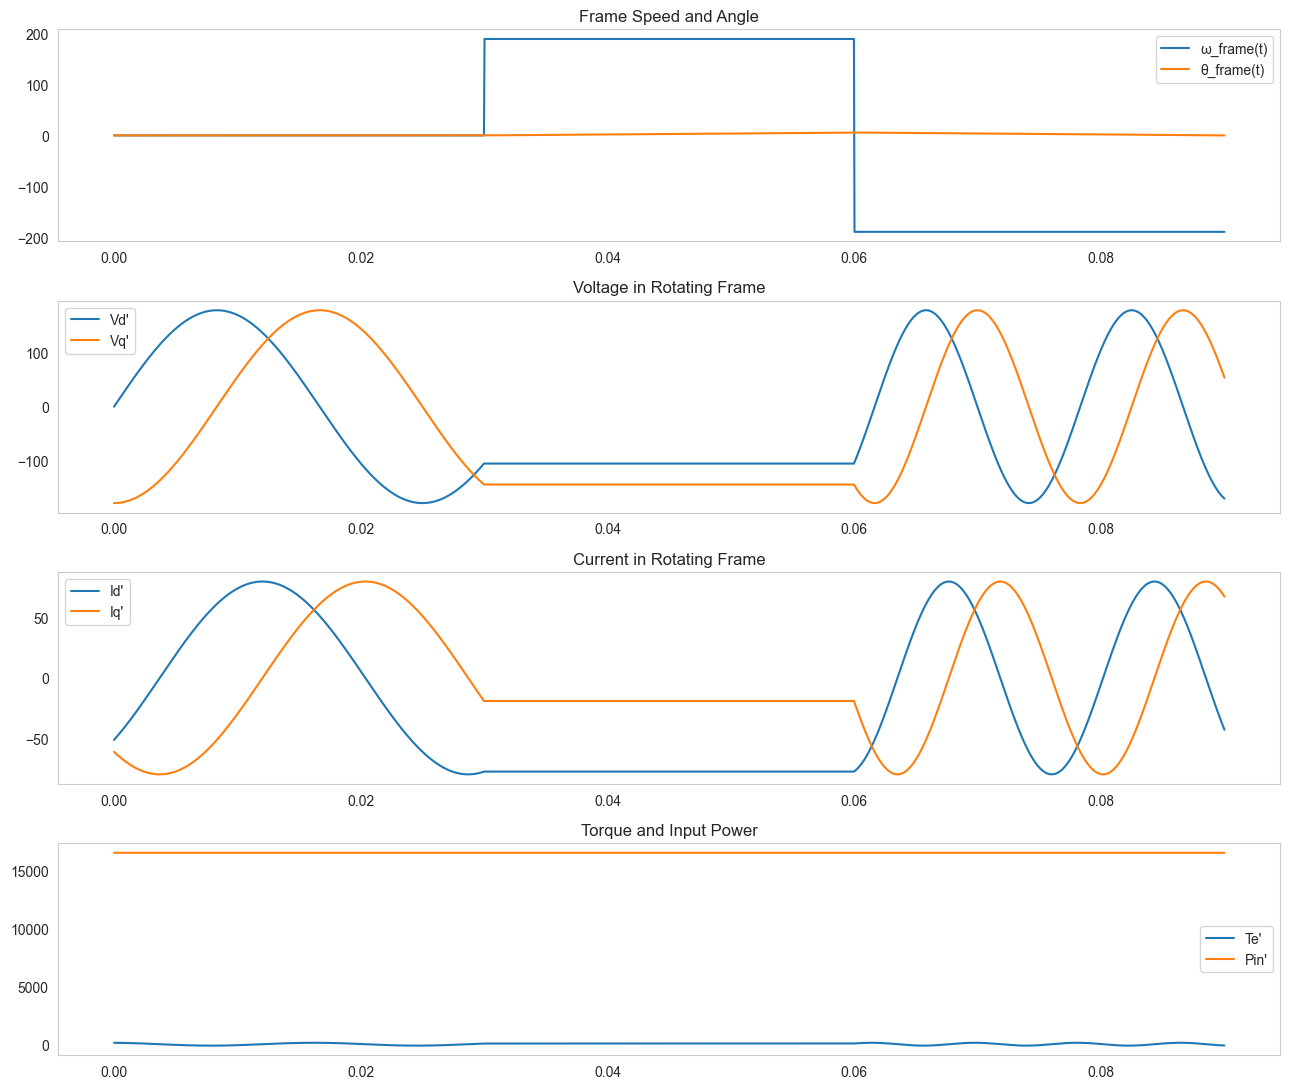

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 모터 파라미터
f = 60
P = 4
w_s = 2 * np.pi * f / (P / 2)
Vll = 220
V1 = Vll / np.sqrt(3)
Vm = np.sqrt(2) * V1
Im = 80
phi = np.deg2rad(40)
Ls = 0.55e-3
Lm = 12.9e-3

# 시간 설정
T_total = 0.09
t = np.linspace(0, T_total, 2000)
dt = t[1] - t[0]

# 좌표계 회전 속도
t1 = T_total / 3
t2 = 2 * T_total / 3
w_frame = np.piecewise(t,
    [t < t1, (t >= t1) & (t < t2), t >= t2],
    [0, w_s, -w_s]
)

# 좌표계 회전각 θ(t) = ∫ ω_frame dt
theta_frame = np.cumsum(w_frame) * dt

# abc 전압/전류 (회전자 정지)
Va = Vm * np.sin(w_s * t)
Vb = Vm * np.sin(w_s * t - 2*np.pi/3)
Vc = Vm * np.sin(w_s * t + 2*np.pi/3)

Ia = Im * np.sin(w_s * t - phi)
Ib = Im * np.sin(w_s * t - 2*np.pi/3 - phi)
Ic = Im * np.sin(w_s * t + 2*np.pi/3 - phi)

# abc → dq 변환 함수
def abc_to_dq(a, b, c, theta):
    alpha = (2/3)*(a - 0.5*b - 0.5*c)
    beta  = (2/3)*(np.sqrt(3)/2)*(b - c)
    d =  alpha * np.cos(theta) + beta * np.sin(theta)
    q = -alpha * np.sin(theta) + beta * np.cos(theta)
    return d, q

# dq 변환 (기준좌표계 회전 반영)
Vd, Vq = abc_to_dq(Va, Vb, Vc, theta_frame)
Id, Iq = abc_to_dq(Ia, Ib, Ic, theta_frame)

# 자속
ld = Ls * Id
lq = Ls * Iq

# 토크 (근사)
Te = 1.5 * (P / 2) * Lm * Id * Iq

# 입력 전력
Pin = 1.5 * (Vd * Id + Vq * Iq)

# 시각화
plt.figure(figsize=(13, 11))

plt.subplot(4, 1, 1)
plt.plot(t, w_frame, label="ω_frame(t)")
plt.plot(t, theta_frame, label="θ_frame(t)")
plt.legend(); plt.grid(); plt.title("Frame Speed and Angle")

plt.subplot(4, 1, 2)
plt.plot(t, Vd, label="Vd'")
plt.plot(t, Vq, label="Vq'")
plt.title("Voltage in Rotating Frame")
plt.legend(); plt.grid()

plt.subplot(4, 1, 3)
plt.plot(t, Id, label="Id'")
plt.plot(t, Iq, label="Iq'")
plt.title("Current in Rotating Frame")
plt.legend(); plt.grid()

plt.subplot(4, 1, 4)
plt.plot(t, Te, label="Te'")
plt.plot(t, Pin, label="Pin'")
plt.title("Torque and Input Power")
plt.legend(); plt.grid()

plt.tight_layout()
plt.show()
